# LSTM neural network used to predict stock prices of Microsoft (MSFT)


### Imports and Data

In [6]:
#Basic imports and set-up

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#Gathering the Data: 

#We will be using yfinance: 

import yfinance as yf
msft=yf.Ticker('MSFT')
msft_info=msft.history(period='max')
msft_info= msft_info.reset_index() #This is to make the date a column as well, so we can call it

In [7]:
#Basic imports and set-up

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#Gathering the Data: 

#We will be using yfinance: 

import yfinance as yf
msft=yf.Ticker('MSFT')
msft_info=msft.history(period='max')
msft_info= msft_info.reset_index() #This is to make the date a column as well, so we can call it

In [8]:
#We will only be using 2 columns from this data frame: date and close. Let's create a data frame with just those 2 columns

msft_close=msft_info[['Date', 'Close']]
#msft_close.index=msft_close.pop('Date') #Make the date back to being the index of this new dataframe 

Text(0.5, 0, 'Year')

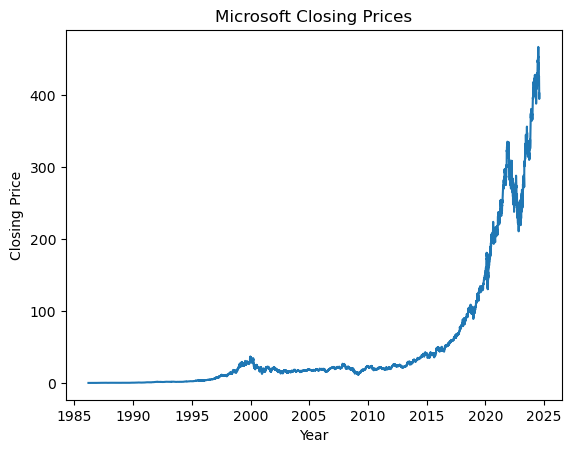

In [10]:
#We can visualize this dataframe now, using the matplotlib library 

plt.plot(msft_close['Date'], msft_close['Close'])
plt.title('Microsoft Closing Prices')
plt.ylabel('Closing Price')
plt.xlabel('Year')

In [14]:
# We need to create the labels, and because this is an LSTM, we have to go back and find what 
#the prices before the date we want the prices for can tells us about curent prices 

n=3 # default, this is the number of days prior that will inform the current closing price 

for i in range (1,n+1): 
    msft_close[f'Close_{i}_days_ago'] = msft_close['Close'].shift(i)

msft_close.dropna(inplace=True)

In [16]:
#Now, let's create separate dataframes for the date, the close price (which is the label) and the prior prices. 
#We also need to make them all arrays for our model, which is why we use the .values attribute of numpy 

#The dates array is useful to find the length of the array we need for our model 
dates = msft_close['Date'].values

#The y array holds all our data labels 
y = msft_close['Close'].values

#The X array holds all our close prices from the three days before for every date. We have to reshape it for the LSTM 
features = msft_close[['Close_1_days_ago', 'Close_2_days_ago', 'Close_3_days_ago']].values
X = features.reshape(len(dates), features.shape[1], 1)

### Splitting, Making and Evaluating the Data

In [18]:
#Now we will use a train/validation/test split 

#Our training dataset will be 80% of our data: 
int80=int(len(dates) * 0.8)
dates_train, X_train, y_train= dates[:int80], X[:int80], y[:int80]

#Our validation dataset will be 10% of our dataset (not used for training): 
int90=int(len(dates) * 0.9)
dates_val, X_val, y_val= dates[int80:int90], X[int80:int90], y[int80:int90]

#Our testing data will be the last 10% of the data we have left: 
dates_test, X_test, y_test= dates[int90:], X[int90:], y[int90:]

In [20]:
# Now we will make our model

#We need to import some functions: 

from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras import layers 

model=Sequential() 
model.add(layers.Input((3,1)))
model.add(layers.LSTM(64))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1)) #Output layer, regression task 
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mean_absolute_error'])

In [21]:
#Now, let's fit the model 

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 162.4887 - mean_absolute_error: 7.4630 - val_loss: 5890.2446 - val_mean_absolute_error: 61.7909
Epoch 2/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - loss: 0.4323 - mean_absolute_error: 0.3882 - val_loss: 5584.8496 - val_mean_absolute_error: 59.0981
Epoch 3/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - loss: 0.4278 - mean_absolute_error: 0.3957 - val_loss: 5527.1763 - val_mean_absolute_error: 58.4300
Epoch 4/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - loss: 0.3628 - mean_absolute_error: 0.3635 - val_loss: 5534.1455 - val_mean_absolute_error: 58.1624
Epoch 5/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - loss: 0.3254 - mean_absolute_error: 0.3315 - val_loss: 5532.1494 - val_mean_absolute_error: 57.8954
Epoch 6/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - loss: 0.3190 - mean_absolute_error: 0.3327 - val_loss: 5569.8174 - val_mean_absolute_error: 58.0416
Epoch 7/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - l

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step


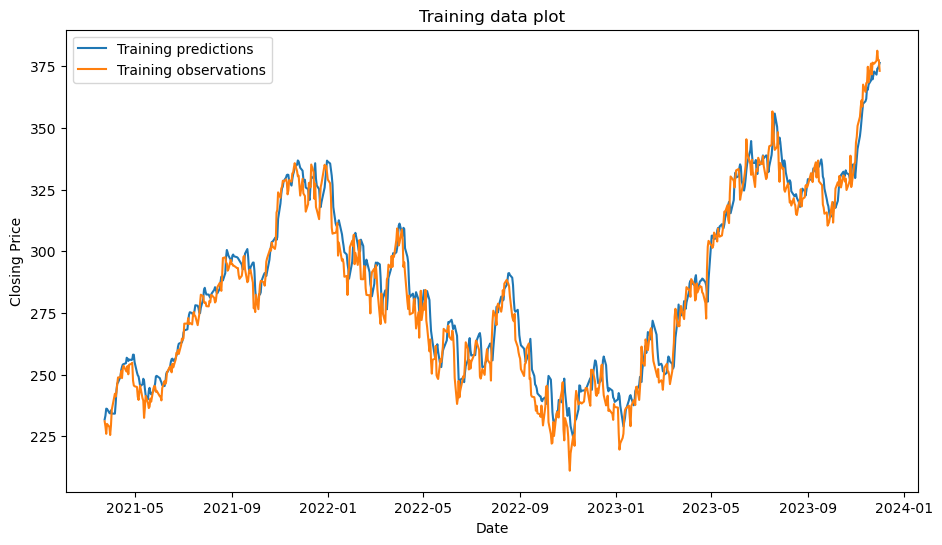

In [287]:
#Now, let's use the model to predict our data: 

#First, let's visualize this with the training data 

training_predictions=model.predict(X_train).flatten()
plt.figure(figsize=(11,6))
plt.plot(dates_train, training_predictions)
plt.plot(dates_train, y_train)
plt.title('Training data plot')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(['Training predictions', 'Training observations'])

#We can see that the lines for observations and predictions are almost overlapping. This makes sense, because our model has seen this data before

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


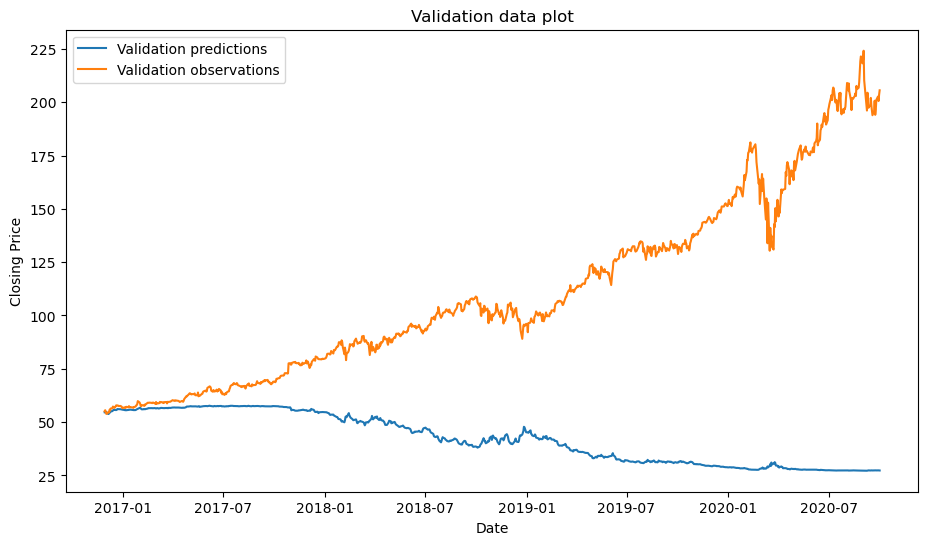

In [23]:
#Now let's do this with our validation data, which our model has NOT been fitted to 

validation_predictions=model.predict(X_val).flatten()
plt.figure(figsize=(11,6))
plt.plot(dates_val, validation_predictions)
plt.plot(dates_val, y_val)
plt.title('Validation data plot')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(['Validation predictions', 'Validation observations'])

# We can see that the predictions are far below the actual closing price observations. 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step


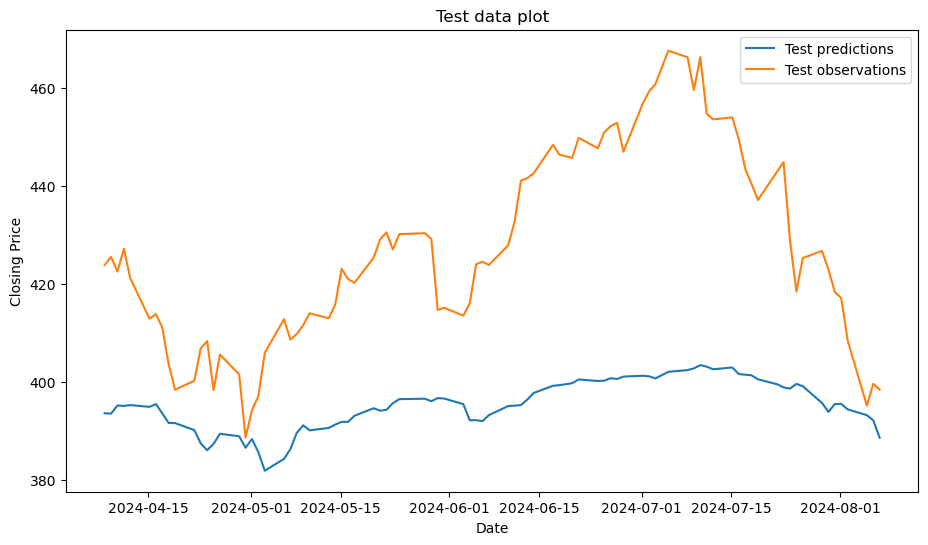

In [283]:
#Let's see how well the LSTM does on the test set 

test_predictions=model.predict(X_test).flatten()
plt.figure(figsize=(11,6))
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.title('Test data plot')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(['Test predictions', 'Test observations'])

#The model performs even worse. This is probably because the prices increase (seemingly) exponentially in the last 20% of the dataset. 
#Our training set does not include data from the last 20% of the overall dataset, which is why the model performs so poorly. 

### Making our model more accurate: using a shorter history for our model

In [24]:
#Instead, let's use a more recent date that is more representative of where our data is currently. 
#Let's use the date March 23, 2020 (arbitrarily). We have to change our dataset now to only include dates on and after that. 

cutoff_date = pd.Timestamp('2021-03-23').tz_localize('America/New_York') #Make sure my cutoff is the correct datatype 
msft_recent=msft_close[msft_close['Date']>=cutoff_date]


In [25]:
#We now need to make arrays again of our data 

#The dates array is useful to find the length of the array we need for our model and to visualize our results 
dates = msft_recent['Date'].values

#The y array holds all our data labels 
y = msft_recent['Close'].values

#The X array holds all our close prices from the three days before for every date. We have to reshape it for the LSTM 
features = msft_recent[['Close_1_days_ago', 'Close_2_days_ago', 'Close_3_days_ago']].values
X = features.reshape(len(dates), features.shape[1], 1)

In [26]:
#We will now resplit our data based on this: (the code does not change, you just have to run it again) 

#Our training dataset will be 80% of our data: 
int80=int(len(dates) * 0.8)
dates_train, X_train, y_train= dates[:int80], X[:int80], y[:int80]

#Our validation dataset will be 10% of our dataset (not used for training): 
int90=int(len(dates) * 0.9)
dates_val, X_val, y_val= dates[int80:int90], X[int80:int90], y[int80:int90]

#Our testing data will be the last 10% of the data we have left: 
dates_test, X_test, y_test= dates[int90:], X[int90:], y[int90:]

In [27]:
#Let's run our model again (no code changes): 

model=Sequential() 
model.add(layers.Input((3,1)))
model.add(layers.LSTM(64))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1)) #Output layer, regression task 
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=250)

Epoch 1/250
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 81076.2578 - mean_absolute_error: 282.3962 - val_loss: 157002.5938 - val_mean_absolute_error: 395.7508
Epoch 2/250
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 80168.4922 - mean_absolute_error: 280.7482 - val_loss: 154745.3438 - val_mean_absolute_error: 392.8885
Epoch 3/250
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 78626.4766 - mean_absolute_error: 277.9839 - val_loss: 149043.1562 - val_mean_absolute_error: 385.5631
Epoch 4/250
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 72840.0234 - mean_absolute_error: 267.3421 - val_loss: 137909.5625 - val_mean_absolute_error: 370.8445
Epoch 5/250
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 64148.8047 - mean_absolute_error: 250.5944 - val_loss: 119105.8203 - val_mean_absolute_error: 344.5606
Epoch 6/250
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 50740.5078 - mean_absolute_error: 222.0262 - val_loss: 94414.3203 - val_mean_absolute_error: 306.6413
Epoch 7/250
22/22 ━━━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


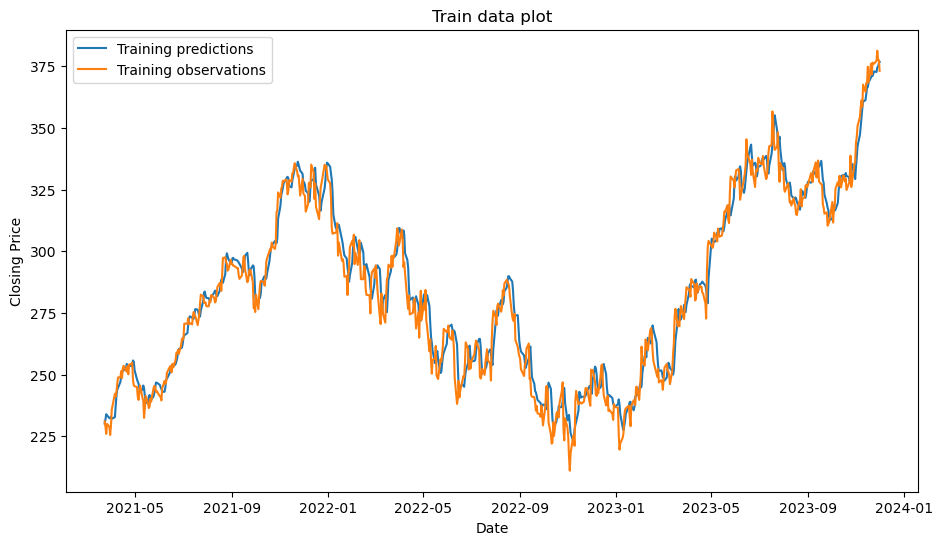

In [28]:
#That went far faster! Let's do the same plots for training, validation, and testing 

training_predictions=model.predict(X_train).flatten()
plt.figure(figsize=(11,6))
plt.plot(dates_train, training_predictions)
plt.plot(dates_train, y_train)
plt.title('Train data plot')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(['Training predictions', 'Training observations'])

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step


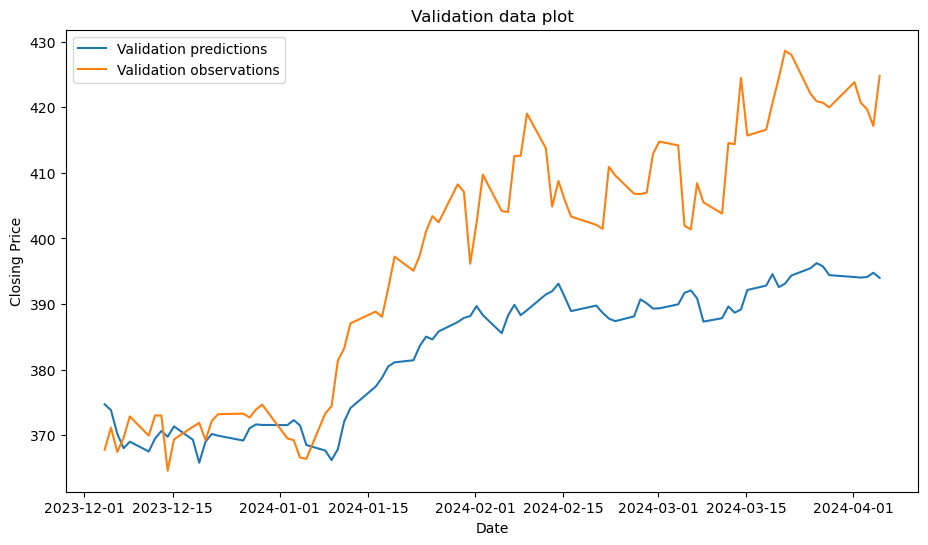

In [277]:
#Validation data set  

validation_predictions=model.predict(X_val).flatten()
plt.figure(figsize=(11,6))
plt.plot(dates_val, validation_predictions)
plt.plot(dates_val, y_val)
plt.title('Validation data plot')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(['Validation predictions', 'Validation observations'])

#We can see that the predictions somewhat keep up with the reality 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step


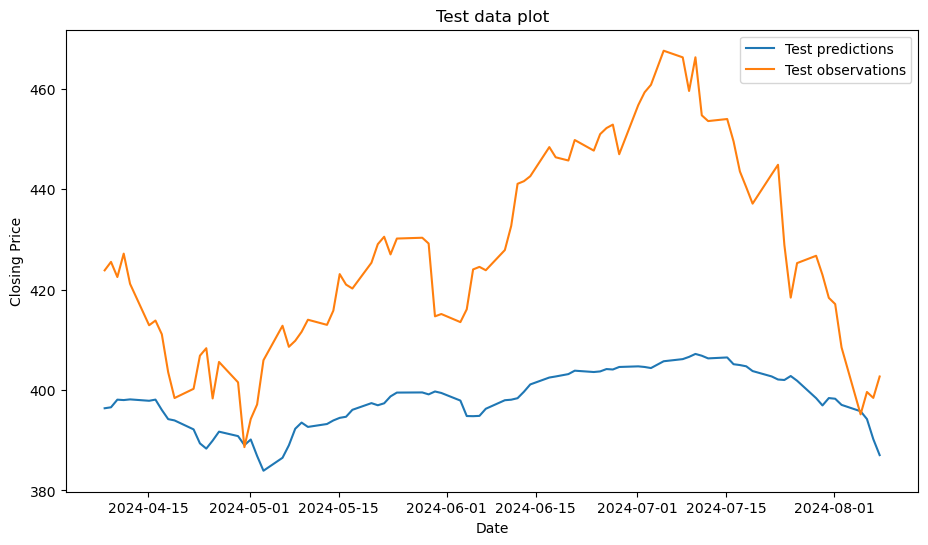

In [30]:
#Testing data set 

test_predictions=model.predict(X_test).flatten()
plt.figure(figsize=(11,6))
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.title('Test data plot')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(['Test predictions', 'Test observations'])

#The predictions for the testing data are not at all reflective of the observations. 
#However, they do portray the overall movement of the stock's closing price.

### Trying to make our model even better: scaling our data's features 

In [31]:
# This model is not very good at predicting stock prices. Let's instead try to scale the data using MinMaxScaler from sklearn

from sklearn.preprocessing import MinMaxScaler 

#Let's go back and get all of our data we used: 
dates = msft_close['Date'].values

#The y array holds all our data labels 
y = msft_close['Close'].values

#The X array holds all our close prices from the three days before for every date. We have to reshape it for the LSTM 
features = msft_close[['Close_1_days_ago', 'Close_2_days_ago', 'Close_3_days_ago']].values
X = features.reshape(len(dates), features.shape[1], 1)

#Our training dataset will be 80% of our data: 
int80=int(len(dates) * 0.8)
dates_train, X_train, y_train= dates[:int80], X[:int80], y[:int80]

#Our validation dataset will be 10% of our dataset (not used for training): 
int90=int(len(dates) * 0.9)
dates_val, X_val, y_val= dates[int80:int90], X[int80:int90], y[int80:int90]

#Our testing data will be the last 10% of the data we have left: 
dates_test, X_test, y_test= dates[int90:], X[int90:], y[int90:]

## Now, let's scale the X values: 

scaler = MinMaxScaler()

#MinMaxScaler can only accept 2D objects, so let's reshape X_train and X_test and then scale them 
X_train_2d = X_train.reshape(-1, 1)
X_val_2d=X_val.reshape(-1,1)
X_test_2d=X_test.reshape(-1,1)

X_train_scaled_2d=scaler.fit_transform(X_train_2d)
X_val_scaled_2d=scaler.fit_transform(X_val_2d)
X_test_scaled_2d=scaler.transform(X_test_2d)

#Now, let's reshape them back 

X_train_scaled = X_train_scaled_2d.reshape(X_train.shape)
X_val_scaled = X_val_scaled_2d.reshape(X_val.shape)
X_test_scaled = X_test_scaled_2d.reshape(X_test.shape)

#Now, let's refit our model 

model.fit(X_train_scaled, y_train, validation_data=(X_val, y_val), epochs=150)

Epoch 1/150
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - loss: 10.3992 - mean_absolute_error: 1.5871 - val_loss: 12932.2383 - val_mean_absolute_error: 110.6341
Epoch 2/150
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 0.2062 - mean_absolute_error: 0.2837 - val_loss: 12571.9248 - val_mean_absolute_error: 108.9970
Epoch 3/150
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 0.2341 - mean_absolute_error: 0.3010 - val_loss: 12154.1211 - val_mean_absolute_error: 107.0916
Epoch 4/150
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - loss: 0.2052 - mean_absolute_error: 0.2803 - val_loss: 11677.5547 - val_mean_absolute_error: 104.9168
Epoch 5/150
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 0.2039 - mean_absolute_error: 0.2859 - val_loss: 11263.2705 - val_mean_absolute_error: 102.9648
Epoch 6/150
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 0.1899 - mean_absolute_error: 0.2678 - val_loss: 10811.8418 - val_mean_absolute_error: 100.8429
Epoch 7/150
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 7

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step


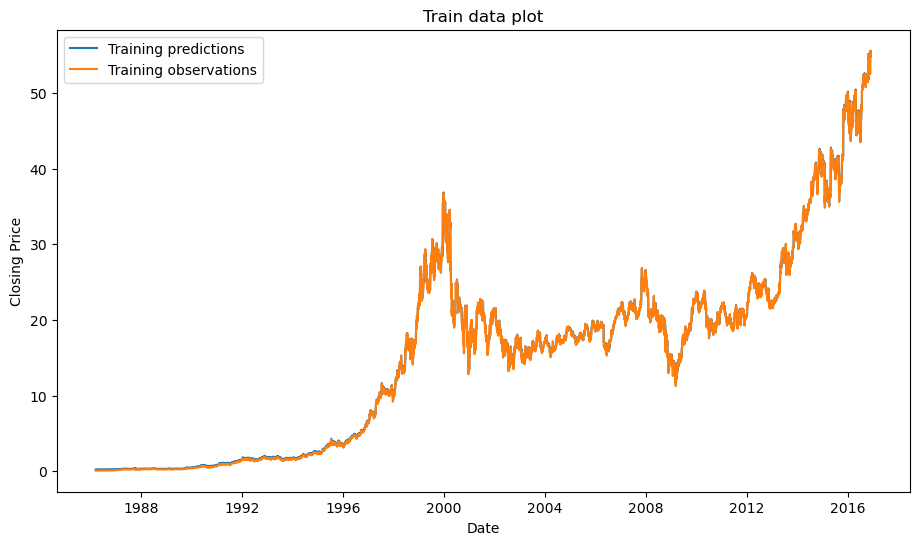

In [327]:
training_predictions=model.predict(X_train_scaled).flatten()
plt.figure(figsize=(11,6))
plt.plot(dates_train, training_predictions)
plt.plot(dates_train, y_train)
plt.title('Train data plot')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(['Training predictions', 'Training observations'])

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step


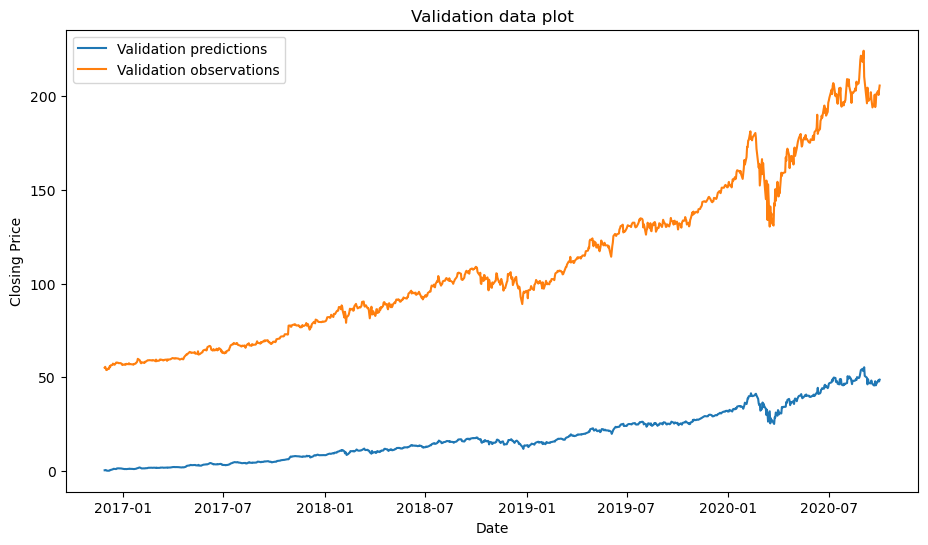

In [32]:
validation_predictions=model.predict(X_val_scaled).flatten()
plt.figure(figsize=(11,6))
plt.plot(dates_val, validation_predictions)
plt.plot(dates_val, y_val)
plt.title('Validation data plot')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(['Validation predictions', 'Validation observations'])

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step


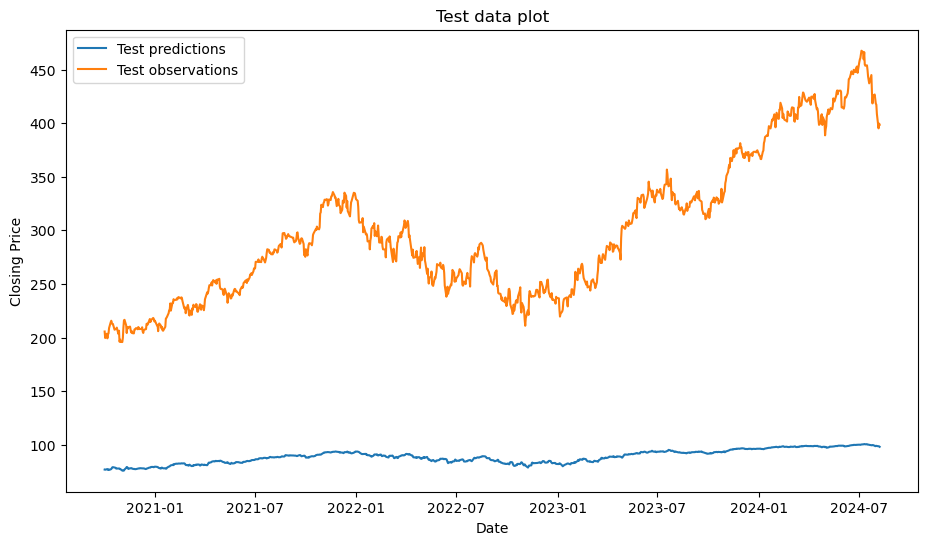

In [331]:
test_predictions=model.predict(X_test).flatten()
plt.figure(figsize=(11,6))
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.title('Test data plot')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(['Test predictions', 'Test observations'])


### Let's mix both of the previous approaches: let's scale the data (using np.log), and use a cutoff date closer to the current date

In [33]:
#Let's go back and get all of our data we used: 

#Let's find an arbitrary cutoff date: 

cutoff_date = pd.Timestamp('2022-03-23').tz_localize('America/New_York') #Make sure my cutoff is the correct datatype 
msft_recent=msft_close[msft_close['Date']>=cutoff_date]

#Let's create arrays (again), but log and X and y arrays 
#The dates give us information to visualize our findings 
dates = msft_recent['Date'].values

#The y array holds all our data labels 
y = np.log(msft_recent['Close']).values

#The X array holds all our close prices from the three days before for every date. We have to reshape it for the LSTM 
features = np.log(msft_recent[['Close_1_days_ago', 'Close_2_days_ago', 'Close_3_days_ago']]).values
X = features.reshape(len(dates), features.shape[1], 1)

#Our training dataset will be 80% of our data: 
int80=int(len(dates) * 0.8)
dates_train, X_train, y_train= dates[:int80], X[:int80], y[:int80]

#Our validation dataset will be 10% of our dataset (not used for training): 
int90=int(len(dates) * 0.9)
dates_val, X_val, y_val= dates[int80:int90], X[int80:int90], y[int80:int90]

#Our testing data will be the last 10% of the data we have left: 
dates_test, X_test, y_test= dates[int90:], X[int90:], y[int90:]

In [34]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3353.8206 - mean_absolute_error: 46.9571 - val_loss: 36.9249 - val_mean_absolute_error: 6.0765
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28.2238 - mean_absolute_error: 5.2942 - val_loss: 20.0340 - val_mean_absolute_error: 4.4759
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14.2041 - mean_absolute_error: 3.7408 - val_loss: 6.8359 - val_mean_absolute_error: 2.6145
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.3487 - mean_absolute_error: 1.7402 - val_loss: 0.1886 - val_mean_absolute_error: 0.4338
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1014 - mean_absolute_error: 0.2619 - val_loss: 0.0251 - val_mean_absolute_error: 0.1571
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1653 - mean_absolute_error: 0.3638 - val_loss: 0.1051 - val_mean_absolute_error: 0.3235
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0263 - mean_absolute_error: 0.1326 - 

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


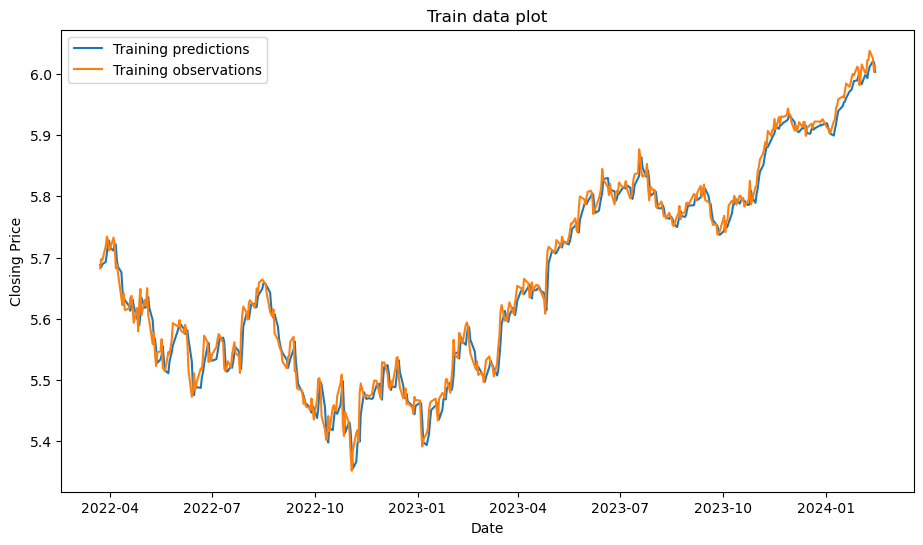

In [361]:
training_predictions=model.predict(X_train).flatten()
plt.figure(figsize=(11,6))
plt.plot(dates_train, training_predictions)
plt.plot(dates_train, y_train)
plt.title('Train data plot')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(['Training predictions', 'Training observations'])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


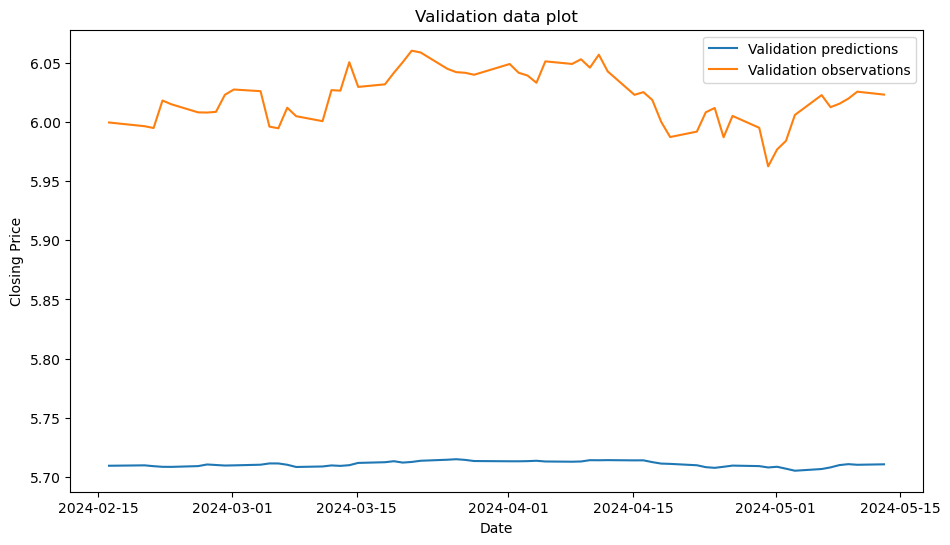

In [35]:
validation_predictions=model.predict(X_val).flatten()
plt.figure(figsize=(11,6))
plt.plot(dates_val, validation_predictions)
plt.plot(dates_val, y_val)
plt.title('Validation data plot')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(['Validation predictions', 'Validation observations'])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


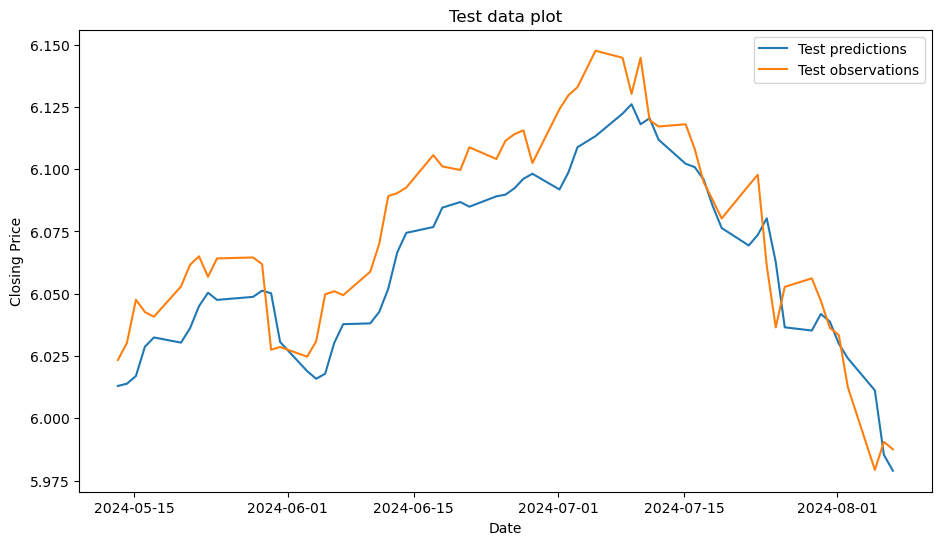

In [354]:
test_predictions=model.predict(X_test).flatten()
plt.figure(figsize=(11,6))
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.title('Test data plot')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(['Test predictions', 'Test observations'])

## We can conclude that our final model: logarithmic scaling and using a shorter time period makes the best model. I will now try this on a different company to see if we can use the same model on a different company.

In [73]:
ticker='AMD'
info=yf.Ticker(ticker)
data=info.history(period='max')
data= data.reset_index()
data_close=data[['Date', 'Close']]

n=3
for i in range (1,n+1): 
    data_close[f'Close_{i}_days_ago'] = data_close['Close'].shift(i)
data_close.dropna(inplace=True)

cutoff_date = pd.Timestamp('2022-03-23').tz_localize('America/New_York') 
data_recent=data_close[data_close['Date']>=cutoff_date]

dates = data_recent['Date'].values
y = np.log(data_recent['Close']).values
features = np.log(data_recent[['Close_1_days_ago', 'Close_2_days_ago', 'Close_3_days_ago']]).values
X = features.reshape(len(dates), features.shape[1], 1)

int80=int(len(dates) * 0.8)
dates_train, X_train, y_train= dates[:int80], X[:int80], y[:int80] 
int90=int(len(dates) * 0.9)
dates_val, X_val, y_val= dates[int80:int90], X[int80:int90], y[int80:int90]
dates_test, X_test, y_test= dates[int90:], X[int90:], y[int90:]

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)



Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0240 - mean_absolute_error: 0.1213 - val_loss: 0.1410 - val_mean_absolute_error: 0.3671
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0208 - mean_absolute_error: 0.1132 - val_loss: 0.1377 - val_mean_absolute_error: 0.3627
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0254 - mean_absolute_error: 0.1259 - val_loss: 0.1347 - val_mean_absolute_error: 0.3585
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0237 - mean_absolute_error: 0.1241 - val_loss: 0.1342 - val_mean_absolute_error: 0.3579
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0241 - mean_absolute_error: 0.1210 - val_loss: 0.1332 - val_mean_absolute_error: 0.3565
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0234 - mean_absolute_error: 0.1186 - val_loss: 0.1338 - val_mean_absolute_error: 0.3573
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0217 - mean_absolute_error: 0.1149 - val_loss

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step


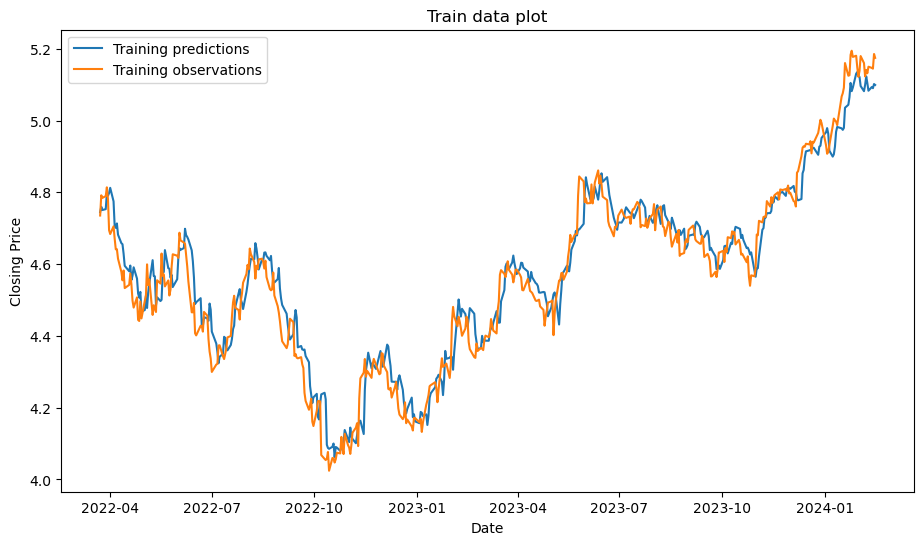

In [75]:
training_predictions=model.predict(X_train).flatten()
plt.figure(figsize=(11,6))
plt.plot(dates_train, training_predictions)
plt.plot(dates_train, y_train)
plt.title('Train data plot')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(['Training predictions', 'Training observations'])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


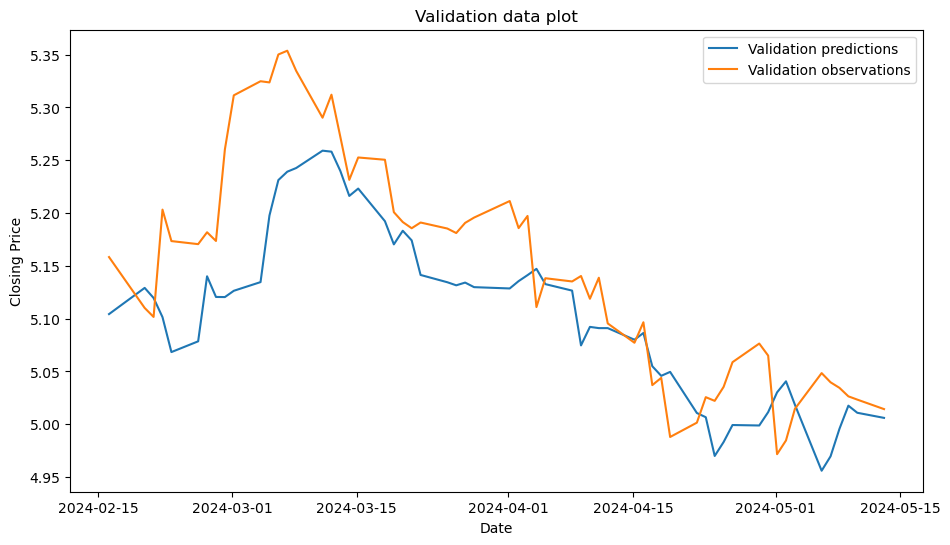

In [77]:
validation_predictions=model.predict(X_val).flatten()
plt.figure(figsize=(11,6))
plt.plot(dates_val, validation_predictions)
plt.plot(dates_val, y_val)
plt.title('Validation data plot')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(['Validation predictions', 'Validation observations'])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


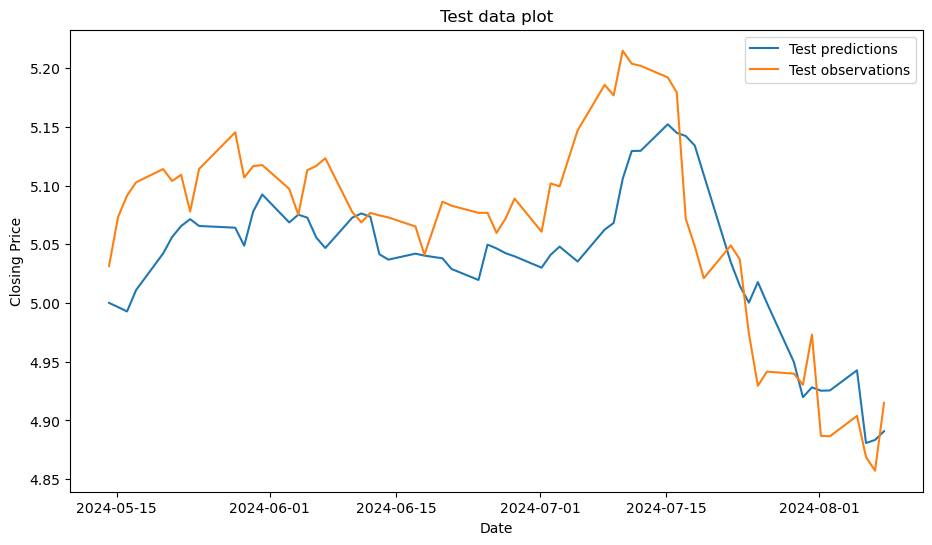

In [79]:
test_predictions=model.predict(X_test).flatten()
plt.figure(figsize=(11,6))
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.title('Test data plot')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(['Test predictions', 'Test observations'])

## We can see that this model works well for AMD as well, and it should work for other companies also. Success!

### Let's try and predict future prices from this model now

In [81]:
# Predict future prices
n_future_steps = 10
last_known_data = X[-1]  # Use the last known input sequence

predicted_prices = []

for _ in range(n_future_steps):
    # Predict the next price
    next_price = model.predict(last_known_data.reshape(1, last_known_data.shape[0], last_known_data.shape[1]))
    predicted_prices.append(next_price[0, 0])
    
    # Update the input sequence
    last_known_data = np.roll(last_known_data, shift=-1, axis=0)
    last_known_data[-1] = next_price

# Convert predictions back from log scale
predicted_prices = np.exp(predicted_prices)

# Generate future dates
last_date = pd.Timestamp(data_recent['Date'].max()).to_pydatetime()
future_dates = [last_date + pd.DateOffset(days=i) for i in range(1, n_future_steps + 1)]

# Create DataFrame for future predictions
future_predictions = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close': predicted_prices
})

future_predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


,Date,Predicted_Close
0,2024-08-09 00:00:00-04:00,133.066193
1,2024-08-10 00:00:00-04:00,132.495285
2,2024-08-11 00:00:00-04:00,131.790146
3,2024-08-12 00:00:00-04:00,131.202179
4,2024-08-13 00:00:00-04:00,130.671356
5,2024-08-14 00:00:00-04:00,130.199722
6,2024-08-15 00:00:00-04:00,129.778412
7,2024-08-16 00:00:00-04:00,129.402100
8,2024-08-17 00:00:00-04:00,129.065506
9,2024-08-18 00:00:00-04:00,128.764359


Text(0, 0.5, 'Predicted Closing Price')

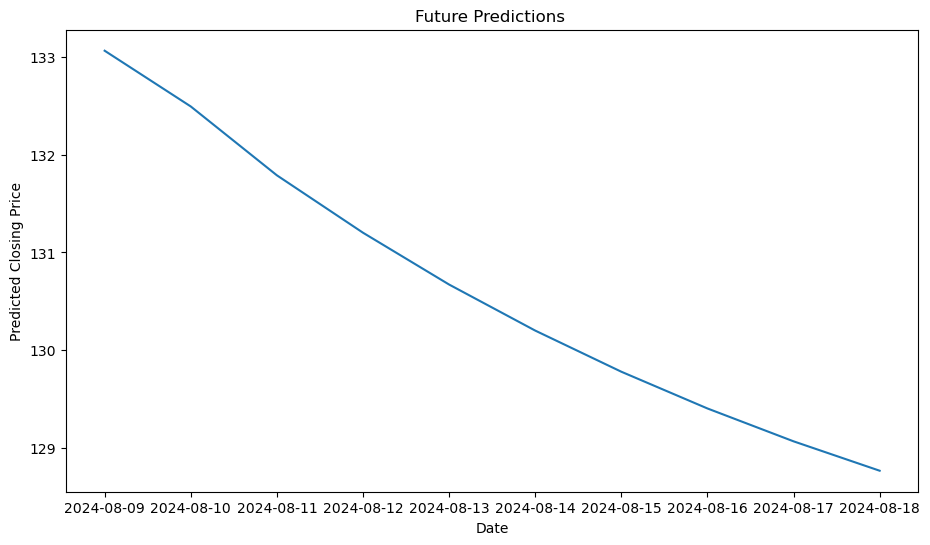

In [83]:
plt.figure(figsize=(11,6))
plt.plot(future_predictions['Date'], future_predictions['Predicted_Close'])
plt.title('Future Predictions ')
plt.xlabel('Date')
plt.ylabel('Predicted Closing Price')